In [75]:
import glob
import re
import os
import datetime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(font="MS Gothic")

import warnings
warnings.filterwarnings('ignore')

In [57]:
def SimpleYield(d, m, p, c):
    t = (m-d).days/365
    return (c + (100-p)/t)/p

In [85]:
ERROR_BBG = '#N/A Field Not Applicable'

def load_bbg_master_file(path):
    
    l = glob.glob(path)
    df = pd.read_excel(l[0])\
                .rename(
                    columns = {
                     '発行体名':'Issuer',
                     'ﾃｨｯｶｰ':'Ticker',
                     'ｸｰﾎﾟﾝ':'Coupon',
                     '満期':'MaturityDate',
                     'ｼﾘｰｽﾞ':'Series',
                     'BBGｺﾝﾎﾟｼﾞｯﾄ':'BBG-composit',
                     '償還ﾀｲﾌﾟ':'PaymentType',
                     '通貨':'CCY',
                     '発行日':'IssueDate',
                     '最終償還日':'LastPaymentDate',
                     'ISINｺｰﾄﾞ':'ISIN',
                     'ｸｰﾎﾟﾝ頻度日数':'CouponCycle',
                    }
                )
    df = df[df['ISIN'] != ERROR_BBG]
    df = df[df['MaturityDate'] != ERROR_BBG]
    
    df['MaturityDate'] = pd.to_datetime(df['MaturityDate'])
    df['IssueDate'] = pd.to_datetime(df['IssueDate'])
    df = df[df['CCY'] == 'JPY']
    
    return df

def load_jgb_master():
    return load_bbg_master_file('../data/master/jgb_master_table.xlsx')

def load_sb_master():
    return load_bbg_master_file('../data/master/corp_bond_master_table.xlsx')


In [86]:
def load_bbg_market_file(path):
    
        isin = re.search(r'(\w+)\scorp_yield.csv', path).group(1)

        df = pd.read_csv(path, parse_dates=['key'])\
                        .rename(
                            columns = {
                                   'key':'BaseDate',
                                   'PX_LAST':'LAST',
                                   'PX_BID':'BID',
                                   ' PX_ASK':'ASK' #何故かスペースがある。
                            }
                        )
        df['ISIN'] = isin
        return df

def load_jgb_market():
    list_path = glob.glob('../data/market/jgb/* corp_yield.csv')
    list_df = []
    
    for path in list_path:
        list_df.append(load_bbg_market_file(path))
    
    df = pd.concat(list_df)
    df = df[df['ISIN'] != '#N/A Field Not Applicable'].sort_values(['BaseDate'])
    return df
    
def load_sb_market():
    list_path = glob.glob('../data/market/corp_bond/* corp_yield.csv')
    list_df = []
    
    for path in list_path:
        list_df.append(load_bbg_market_file(path))
        
    df = pd.concat(list_df)
    df = df[df['ISIN'] != '#N/A Field Not Applicable'].sort_values(['BaseDate'])

    return df

In [105]:
def setup():
    
    kinds = ['JN','JS','JB','JL','JX','JU']
    
    df_jgb_master = load_jgb_master()
    df_jgb_market = load_jgb_market()
    df_sb_master = load_sb_master()
    df_sb_market = load_sb_market()
    
    def GetKind(isin):
        return  "JN" if isin.startswith("JP102") else\
                "JS" if isin.startswith("JP105") else\
                "JB" if isin.startswith("JP110") else\
                "JL" if isin.startswith("JP120") else\
                "JX" if isin.startswith("JP130") else\
                "JU" if isin.startswith("JP140") else\
                "Unknown"
    
    def GetCurrentInfo():
        
        df_dates =pd.DataFrame({'BaseDate':df_jgb_market['BaseDate'].unique()}).sort_values(['BaseDate'])
        df_jgb_master_copy = df_jgb_master.copy()
        df_jgb_master_copy = df_jgb_master_copy.sort_values(['IssueDate'])

        list_df = []
        for k in df_jgb_master['Kind'].unique():

            df = pd.merge_asof(df_dates, 
                               df_jgb_master_copy[df_jgb_master_copy['Kind'] == k][['IssueDate','ISIN']], 
                               left_on = 'BaseDate', 
                               right_on='IssueDate')

            df['Kind'] = k

            list_df.append(df)
    
        return pd.concat(list_df)
    
    def GetIsOmote(kind, ys):
        
        if kind == "JN" and 1.0 <= ys:
            return True
        
        if kind == "JS" and 2.0 <= ys:
            return True
        
        if kind == "JB" and 5.0 <= ys:
            return True

        if kind == "JL" and 10.0 <= ys:
            return True

        if kind == "JX" and 20.0 <= ys:
            return True

        if kind == "JU" and 30.0 <= ys:
            return True
        
        return False
        
    #JGBマスタ
    df_jgb_master['Kind'] = df_jgb_master['ISIN'].apply(lambda x: GetKind(x))

    #JGBマーケット
    df_jgb_market['Kind'] = df_jgb_market['ISIN'].apply(lambda x: GetKind(x))
    df_jgb_market = pd.merge(df_jgb_market, df_jgb_master[['ISIN','MaturityDate']], on=['ISIN'])
    df_jgb_market['Ys'] = df_jgb_market.apply(lambda r: (r['MaturityDate']-r['BaseDate']).days/365, axis=1)
    df_jgb_market['IsOmote'] = df_jgb_market.apply(lambda r: GetIsOmote(r['Kind'], r['Ys']), axis=1)

    #JGBカレント
    df_jgb_current = GetCurrentInfo()
    df_jgb_current = pd.merge(df_jgb_current, df_jgb_market[['BaseDate','ISIN','LAST','BID','ASK']], on=['BaseDate','ISIN'])
    
    #SBマスタ
    for k in kinds:
        df_sb_market = pd.merge(
            df_sb_market, 
            df_jgb_current.rename(columns={'LAST':'LAST_'+k})[df_jgb_current['Kind']==k][['BaseDate','LAST_'+k]], 
            on=['BaseDate'])
    
    #SBマーケット
    df_sb_market = pd.merge(df_sb_market, df_sb_master[['ISIN','MaturityDate','Coupon']], on=['ISIN'])
    df_sb_market['LAST'] = df_sb_market.apply(lambda r: 
                    SimpleYield(r['BaseDate'],r['MaturityDate'],r['LAST'],r['Coupon']) if r['LAST'] > 50 else r['LAST'], axis=1)
    df_sb_market['ASK'] = df_sb_market.apply(lambda r: 
                    SimpleYield(r['BaseDate'],r['MaturityDate'],r['ASK'],r['Coupon']) if r['ASK'] > 50 else r['ASK'], axis=1)
    df_sb_market['BID'] = df_sb_market.apply(lambda r: 
                    SimpleYield(r['BaseDate'],r['MaturityDate'],r['BID'],r['Coupon']) if r['BID'] > 50 else r['BID'], axis=1)
 
    df_sb_market['NEAREST_JGB'] = "missing"
    df_sb_market['LAST_NEAREST_JGB'] = np.nan
    for index, row in df_sb_market.iterrows():
        df = df_jgb_market[(
                (df_jgb_market['BaseDate'] == row['BaseDate'])&
                (df_jgb_market['IsOmote'])&
                (row['MaturityDate'] <= df_jgb_market['MaturityDate']))].sort_values(['MaturityDate']).head(1)

        df_sb_market.set_value(index,'NEAREST_JGB',df['ISIN'].values[0])
        df_sb_market.set_value(index,'LAST_NEAREST_JGB',df['LAST'].values[0])

    return df_jgb_master,\
           df_jgb_market,\
           df_jgb_current,\
           df_sb_master,\
           df_sb_market

In [106]:
df_jgb_master, df_jgb_market, df_jgb_current, df_sb_master, df_sb_market = setup()

In [107]:
df_jgb_master.head(1)

,Issuer,Ticker,Coupon,MaturityDate,Series,BBG-composit,PaymentType,CCY,IssueDate,LastPaymentDate,ISIN,CouponCycle,ID_CUSIP,Kind
0,日本国債(2年),JGB,0.1,2022-03-01,410,NR,AT MATURITY,JPY,2020-03-02,2022/03/01,JP1024101L33,S/A,BG3829135,JN


In [108]:
df_jgb_market.head(1)

,BaseDate,LAST,BID,ASK,ISIN,Kind,MaturityDate,Ys,IsOmote
0,2016-01-01,-0.014,-0.009,-0.019,JP1023601G11,JN,2018-01-15,2.041096,True


In [109]:
df_jgb_current.head(1)

,BaseDate,IssueDate,ISIN,Kind,LAST,BID,ASK
0,2016-01-15,2016-01-15,JP1023601G11,JN,-0.034,-0.019,-0.049


In [110]:
df_sb_master.head(1)

,Issuer,Ticker,Coupon,MaturityDate,Series,BBG-composit,PaymentType,CCY,IssueDate,LastPaymentDate,ISIN,CouponCycle,ID_CUSIP
0,富士通,FUJITS,0.533,2022-07-22,38,NaN,AT MATURITY,JPY,2015-07-22,2022/07/22,JP381800BF71,S/A,AF1717665


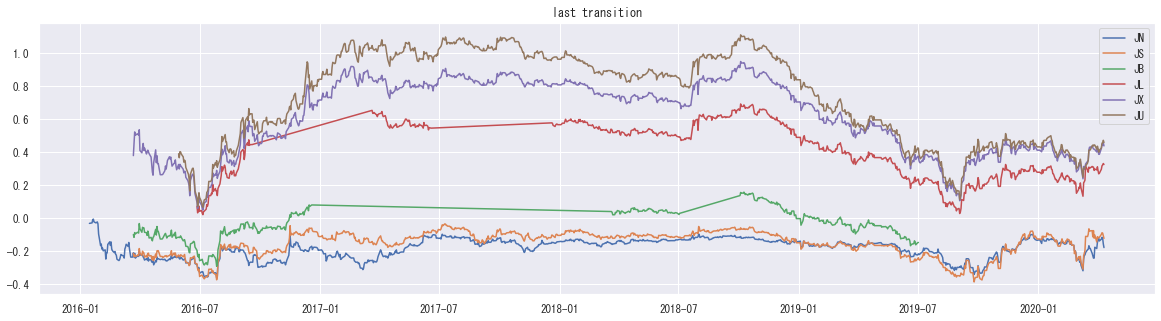

In [111]:
def plot_last_transition():
    
    kinds = ['JN','JS','JB','JL','JX','JU']
    plt.figure(figsize=(20,5))

    for k in kinds:
        df = df_jgb_current[df_jgb_current['Kind'] == k]
        plt.plot(df['BaseDate'], df['LAST'], label=k)
        
    plt.title("last transition")
    plt.legend()
    
plot_last_transition()

## 変数

+ 発行体

[Text(0, 0, '富士通'),
 Text(0, 0, '日立製作所'),
 Text(0, 0, '三井住友ﾌｨﾅﾝｼｬﾙｸﾞﾙｰﾌﾟ'),
 Text(0, 0, '伊藤忠商事'),
 Text(0, 0, 'マツダ'),
 Text(0, 0, 'トヨタ自動車'),
 Text(0, 0, 'トヨタファイナンス'),
 Text(0, 0, 'ソフトバンクグループ'),
 Text(0, 0, 'エヌ・ティ・ティ・データ'),
 Text(0, 0, 'ＳＢＩホールディングス')]

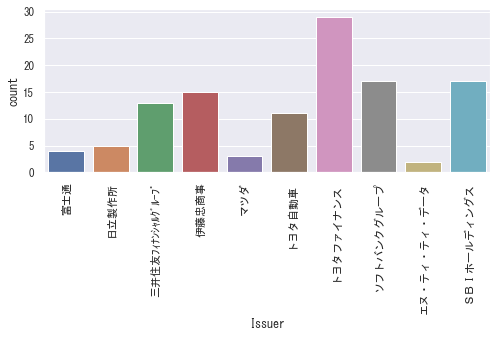

In [112]:
plt.figure(figsize=(8,3))
g = sns.countplot(x='Issuer', data=df_sb_master)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

+ 信用格付け（BBG-composit）
     + NRは格付けが付与されていない(?)

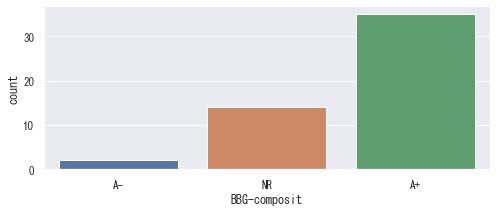

In [113]:
plt.figure(figsize=(8,3))
sns.countplot(x='BBG-composit', data = df_sb_master)

+ クーポン

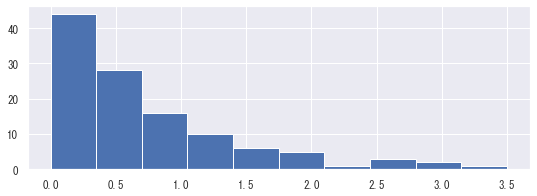

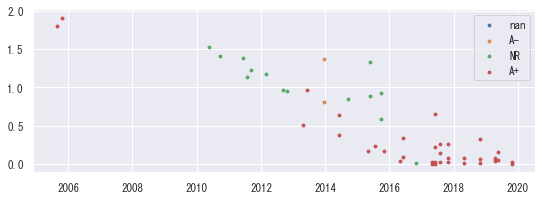

In [152]:
plt.figure(figsize=(9,3))
plt.hist(df_sb_master['Coupon'])
plt.show()

plt.figure(figsize=(9,3))

for rank in df_sb_master['BBG-composit'].unique():
    plt.scatter(df_sb_master[df_sb_master['BBG-composit']==rank]['IssueDate'], df_sb_master[df_sb_master['BBG-composit']==rank]['Coupon'], s=8, label=rank)

plt.legend()
plt.show()

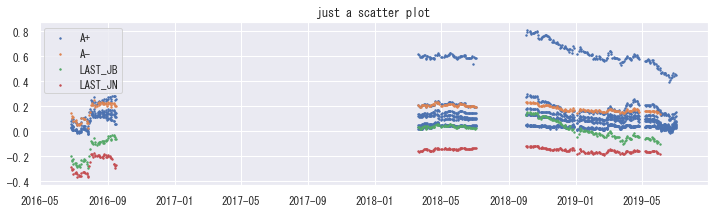

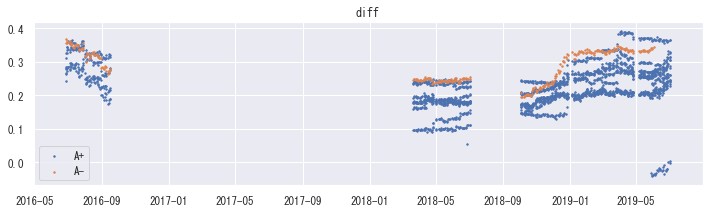

In [153]:
tmp = df_sb_market.copy()
tmp['DIFF_LAST_NEAR_JGB'] = tmp['LAST'] - tmp['LAST_NEAREST_JGB']
tmp = pd.merge(tmp, df_sb_master[['ISIN','Issuer','BBG-composit']], on=['ISIN'], how='inner')
tmp_Aplus = tmp[tmp['BBG-composit'] == 'A+']
tmp_Amins = tmp[tmp['BBG-composit'] == 'A-']

plt.figure(figsize=(12,3))

plt.title("just a scatter plot")
plt.scatter(tmp_Aplus['BaseDate'], tmp_Aplus['LAST'], s=2, label="A+")
plt.scatter(tmp_Amins['BaseDate'], tmp_Amins['LAST'], s=2, label="A-")
plt.scatter(tmp_Amins['BaseDate'], tmp_Amins['LAST_JB'], s=2, label="LAST_JB")
plt.scatter(tmp_Amins['BaseDate'], tmp_Amins['LAST_JN'], s=2, label="LAST_JN")

plt.legend()
plt.show()


plt.figure(figsize=(12,3))

plt.title("diff")
plt.scatter(tmp_Aplus['BaseDate'], tmp_Aplus['DIFF_LAST_NEAR_JGB'], s=2, label="A+")
plt.scatter(tmp_Amins['BaseDate'], tmp_Amins['DIFF_LAST_NEAR_JGB'], s=2, label="A-")

plt.legend()
plt.show()


In [122]:

tmp_Amins['Issuer'].unique()

array(['日立製作所'], dtype=object)